In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

<Axes: ylabel='Frequency'>

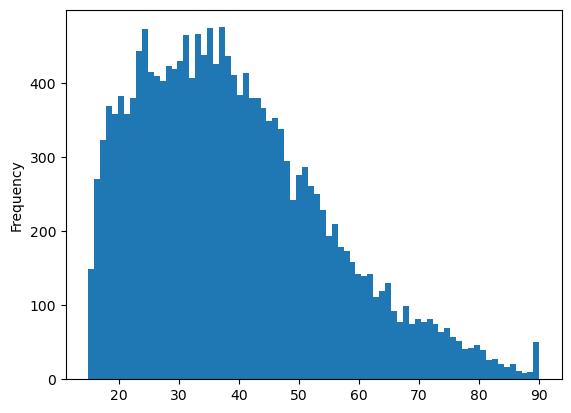

In [3]:
train[train['Age'] > 14]['Age'].plot.hist(bins=90-14)

<Axes: ylabel='Frequency'>

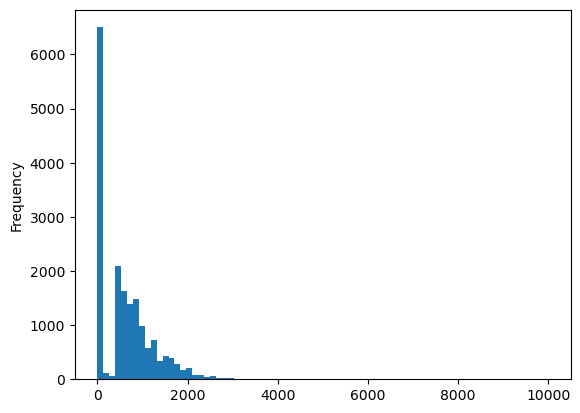

In [4]:
train[train['Age'] > 14]['Income'].plot.hist(bins=90-14)

In [10]:
train[train['Age'] < 15]['Income'].mean()

0.0

In [14]:
tp = train[['Education_Status','Age','Income']]
tp[tp['Age'] > 15].groupby('Education_Status').mean()

,Age,Income
Education_Status,,
Associates degree (Academic),38.141215,782.740558
Associates degree (Vocational),39.929825,867.269906
Bachelors degree,39.136503,699.367076
College,36.234581,651.468108
Doctorate degree,48.551724,575.528736
Elementary (1-4),49.186667,343.440000
Elementary (5-6),45.649842,325.116719
High Freshman,37.182952,405.316008
High Junior,32.793651,483.623932


In [35]:
from pycaret.regression import *

# 데이터 불러오기 (보스턴 주택 가격 데이터셋 사용)
data = train[(train['Age'] > 15) & (train['Income'] < 2500)]
data = data.drop('ID',axis=1)
# PyCaret 회귀 모델 설정
regression_setup = setup(data, target='Income',
                         max_encoding_ohe=5,
                         train_size=0.8,
                         fold=5,
                         session_id=42)

# 다양한 회귀 모델 비교
best_model = compare_models(n_select=3, sort='RMSE')

,Description,Value
0,Session id,42
1,Target,Income
2,Target type,Regression
3,Original data shape,"(17415, 22)"
4,Transformed data shape,"(17415, 32)"
5,Transformed train set shape,"(13932, 32)"
6,Transformed test set shape,"(3483, 32)"
7,Ordinal features,1
8,Numeric features,5
9,Categorical features,16


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,334.0880,221690.6275,470.8194,0.3195,3.1900,0.3018,0.1400
catboost,CatBoost Regressor,336.0481,222614.5537,471.7952,0.3167,3.2674,0.3053,1.3600
gbr,Gradient Boosting Regressor,340.8087,223572.9717,472.8200,0.3137,3.2695,0.3022,0.3460
rf,Random Forest Regressor,339.1766,231142.1028,480.7571,0.2903,3.0494,0.3195,1.1140
xgboost,Extreme Gradient Boosting,344.1920,234941.3825,484.6352,0.2789,3.2584,0.3270,0.4120
en,Elastic Net,359.9623,235159.7147,484.9187,0.2782,3.4803,0.3028,0.1280
lasso,Lasso Regression,360.1691,235161.3934,484.9195,0.2782,3.4849,0.3024,0.6180
llar,Lasso Least Angle Regression,360.1691,235161.3966,484.9195,0.2782,3.4849,0.3024,0.1300
br,Bayesian Ridge,360.0002,235468.5828,485.2367,0.2773,3.4725,0.3038,0.1420
ridge,Ridge Regression,360.5441,235588.4479,485.3581,0.2769,3.4881,0.3027,0.1300


In [68]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# 데이터 불러오기 (예시로는 보스턴 주택 가격 데이터셋 사용)

object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000)].drop('ID',axis=1)
X = data.drop('Income',axis=1)
y = data[['Income']]

# 훈련/테스트 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

def objective(trial):
    # 하이퍼파라미터 검색 범위 지정
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    
    # 교차 검증 설정 (5-Fold 교차 검증 사용)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    rmse_scores = []

    for train_index, valid_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

        # LightGBM 모델 정의
        model = lgb.LGBMRegressor(**params)

        # 모델 훈련
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        # 검증 데이터로 RMSE 계산
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # 교차 검증 평균 RMSE 반환
    return np.mean(rmse_scores)

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# 최적화된 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-03-15 00:59:43,887] A new study created in memory with name: no-name-4e31a75a-36ff-41df-a211-e79607113913


[LightGBM] [Warning] feature_fraction is set=0.7600144325320426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7600144325320426
[LightGBM] [Warning] bagging_fraction is set=0.7143473864013581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7143473864013581
[LightGBM] [Warning] lambda_l1 is set=2.3999886785131978e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3999886785131978e-05
[LightGBM] [Warning] lambda_l2 is set=4.499660327513821e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.499660327513821e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7600144325320426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7600144325320426
[LightGBM] [Warning] bagging_fraction is set=0.7143473864013581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7143473864013581
[LightGBM

[I 2024-03-15 00:59:45,722] Trial 0 finished with value: 591.1539836334908 and parameters: {'lambda_l1': 2.3999886785131978e-05, 'lambda_l2': 4.499660327513821e-06, 'num_leaves': 126, 'learning_rate': 5.1413777546783216e-05, 'feature_fraction': 0.7600144325320426, 'bagging_fraction': 0.7143473864013581, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 0 with value: 591.1539836334908.


[LightGBM] [Warning] feature_fraction is set=0.45073651123341707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45073651123341707
[LightGBM] [Warning] bagging_fraction is set=0.5588643707956522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5588643707956522
[LightGBM] [Warning] lambda_l1 is set=0.00020980696680262517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020980696680262517
[LightGBM] [Warning] lambda_l2 is set=0.1794329168936802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1794329168936802
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.45073651123341707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45073651123341707
[LightGBM] [Warning] bagging_fraction is set=0.5588643707956522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5588643707956522
[LightGBM] 

[I 2024-03-15 00:59:47,537] Trial 1 finished with value: 507.3583700628956 and parameters: {'lambda_l1': 0.00020980696680262517, 'lambda_l2': 0.1794329168936802, 'num_leaves': 159, 'learning_rate': 0.9768918027571968, 'feature_fraction': 0.45073651123341707, 'bagging_fraction': 0.5588643707956522, 'bagging_freq': 2, 'min_child_samples': 6}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.9587313095501039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9587313095501039
[LightGBM] [Warning] bagging_fraction is set=0.9142964836924036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9142964836924036
[LightGBM] [Warning] lambda_l1 is set=4.673185592888827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.673185592888827
[LightGBM] [Warning] lambda_l2 is set=2.450064358931509e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.450064358931509e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9587313095501039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9587313095501039
[LightGBM] [Warning] bagging_fraction is set=0.9142964836924036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9142964836924036
[LightGBM] [Warning

[I 2024-03-15 00:59:48,989] Trial 2 finished with value: 592.0352970446254 and parameters: {'lambda_l1': 4.673185592888827, 'lambda_l2': 2.450064358931509e-08, 'num_leaves': 180, 'learning_rate': 1.662139672023861e-07, 'feature_fraction': 0.9587313095501039, 'bagging_fraction': 0.9142964836924036, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.7332490130355707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7332490130355707
[LightGBM] [Warning] bagging_fraction is set=0.5014522702521437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5014522702521437
[LightGBM] [Warning] lambda_l1 is set=4.874359065767741, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.874359065767741
[LightGBM] [Warning] lambda_l2 is set=1.6450690374102856e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6450690374102856e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7332490130355707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7332490130355707
[LightGBM] [Warning] bagging_fraction is set=0.5014522702521437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5014522702521437
[LightGBM] [Warni

[I 2024-03-15 00:59:50,004] Trial 3 finished with value: 591.9253061715679 and parameters: {'lambda_l1': 4.874359065767741, 'lambda_l2': 1.6450690374102856e-06, 'num_leaves': 105, 'learning_rate': 6.8924479285507625e-06, 'feature_fraction': 0.7332490130355707, 'bagging_fraction': 0.5014522702521437, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.445636812962966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.445636812962966
[LightGBM] [Warning] bagging_fraction is set=0.8587441479670992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8587441479670992
[LightGBM] [Warning] lambda_l1 is set=1.4557466978499258e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4557466978499258e-06
[LightGBM] [Warning] lambda_l2 is set=6.114602129192208e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.114602129192208e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.445636812962966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.445636812962966
[LightGBM] [Warning] bagging_fraction is set=0.8587441479670992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8587441479670992
[LightGBM] [W

[I 2024-03-15 00:59:51,753] Trial 4 finished with value: 591.9869678611889 and parameters: {'lambda_l1': 1.4557466978499258e-06, 'lambda_l2': 6.114602129192208e-06, 'num_leaves': 181, 'learning_rate': 3.6640070000040805e-06, 'feature_fraction': 0.445636812962966, 'bagging_fraction': 0.8587441479670992, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.5575204689627461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5575204689627461
[LightGBM] [Warning] bagging_fraction is set=0.7919128310734336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919128310734336
[LightGBM] [Warning] lambda_l1 is set=2.842539966198598e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.842539966198598e-06
[LightGBM] [Warning] lambda_l2 is set=5.360210856699188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.360210856699188
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5575204689627461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5575204689627461
[LightGBM] [Warning] bagging_fraction is set=0.7919128310734336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919128310734336
[LightGBM] [Warning

[I 2024-03-15 00:59:52,969] Trial 5 finished with value: 591.231598968941 and parameters: {'lambda_l1': 2.842539966198598e-06, 'lambda_l2': 5.360210856699188, 'num_leaves': 94, 'learning_rate': 5.317321656479729e-05, 'feature_fraction': 0.5575204689627461, 'bagging_fraction': 0.7919128310734336, 'bagging_freq': 4, 'min_child_samples': 97}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.6126952515946331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6126952515946331
[LightGBM] [Warning] bagging_fraction is set=0.6928349809150594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6928349809150594
[LightGBM] [Warning] lambda_l1 is set=3.3768767580318e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3768767580318e-05
[LightGBM] [Warning] lambda_l2 is set=1.3120827228020722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3120827228020722
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6126952515946331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6126952515946331
[LightGBM] [Warning] bagging_fraction is set=0.6928349809150594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6928349809150594
[LightGBM] [Warning] 

[I 2024-03-15 00:59:54,206] Trial 6 finished with value: 592.0372191135735 and parameters: {'lambda_l1': 3.3768767580318e-05, 'lambda_l2': 1.3120827228020722, 'num_leaves': 249, 'learning_rate': 6.338836586421563e-08, 'feature_fraction': 0.6126952515946331, 'bagging_fraction': 0.6928349809150594, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.7772221996258488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7772221996258488
[LightGBM] [Warning] bagging_fraction is set=0.49083779280646767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49083779280646767
[LightGBM] [Warning] lambda_l1 is set=1.9864916081845013e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9864916081845013e-05
[LightGBM] [Warning] lambda_l2 is set=0.00020869476114662662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020869476114662662
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7772221996258488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7772221996258488
[LightGBM] [Warning] bagging_fraction is set=0.49083779280646767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49083779280646767
[Li

[I 2024-03-15 00:59:55,518] Trial 7 finished with value: 591.739688536414 and parameters: {'lambda_l1': 1.9864916081845013e-05, 'lambda_l2': 0.00020869476114662662, 'num_leaves': 86, 'learning_rate': 1.772169104856332e-05, 'feature_fraction': 0.7772221996258488, 'bagging_fraction': 0.49083779280646767, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.6531909682926704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6531909682926704
[LightGBM] [Warning] bagging_fraction is set=0.8417636271885889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8417636271885889
[LightGBM] [Warning] lambda_l1 is set=1.4472157502557155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4472157502557155
[LightGBM] [Warning] lambda_l2 is set=7.53649194527135e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.53649194527135e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6531909682926704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6531909682926704
[LightGBM] [Warning] bagging_fraction is set=0.8417636271885889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8417636271885889
[LightGBM] [Warning

[I 2024-03-15 00:59:56,874] Trial 8 finished with value: 592.037572886529 and parameters: {'lambda_l1': 1.4472157502557155, 'lambda_l2': 7.53649194527135e-07, 'num_leaves': 64, 'learning_rate': 3.8858525366977224e-08, 'feature_fraction': 0.6531909682926704, 'bagging_fraction': 0.8417636271885889, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.53374713664054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53374713664054
[LightGBM] [Warning] bagging_fraction is set=0.8746574665771183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8746574665771183
[LightGBM] [Warning] lambda_l1 is set=0.00046901032224304476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00046901032224304476
[LightGBM] [Warning] lambda_l2 is set=3.867878111099673e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.867878111099673e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.53374713664054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53374713664054
[LightGBM] [Warning] bagging_fraction is set=0.8746574665771183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8746574665771183
[LightGBM] [Warni

[I 2024-03-15 00:59:58,325] Trial 9 finished with value: 574.9936270664205 and parameters: {'lambda_l1': 0.00046901032224304476, 'lambda_l2': 3.867878111099673e-08, 'num_leaves': 240, 'learning_rate': 0.0012387893737361955, 'feature_fraction': 0.53374713664054, 'bagging_fraction': 0.8746574665771183, 'bagging_freq': 2, 'min_child_samples': 86}. Best is trial 1 with value: 507.3583700628956.


[LightGBM] [Warning] feature_fraction is set=0.4007496709630228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4007496709630228
[LightGBM] [Warning] bagging_fraction is set=0.5838163886889823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5838163886889823
[LightGBM] [Warning] lambda_l1 is set=1.1308668077750956e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1308668077750956e-08
[LightGBM] [Warning] lambda_l2 is set=0.06759137888810213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06759137888810213
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4007496709630228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4007496709630228
[LightGBM] [Warning] bagging_fraction is set=0.5838163886889823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5838163886889823
[LightGBM] [W

[I 2024-03-15 00:59:58,730] Trial 10 finished with value: 498.1284961505804 and parameters: {'lambda_l1': 1.1308668077750956e-08, 'lambda_l2': 0.06759137888810213, 'num_leaves': 2, 'learning_rate': 0.33200725602903935, 'feature_fraction': 0.4007496709630228, 'bagging_fraction': 0.5838163886889823, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 10 with value: 498.1284961505804.


[LightGBM] [Warning] feature_fraction is set=0.4007496709630228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4007496709630228
[LightGBM] [Warning] bagging_fraction is set=0.5838163886889823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5838163886889823
[LightGBM] [Warning] lambda_l1 is set=1.1308668077750956e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1308668077750956e-08
[LightGBM] [Warning] lambda_l2 is set=0.06759137888810213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06759137888810213
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4007496709630228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4007496709630228
[LightGBM] [Warning] bagging_fraction is set=0.5838163886889823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5838163886889823
[LightGBM] [W

[I 2024-03-15 00:59:59,323] Trial 11 finished with value: 505.270904763902 and parameters: {'lambda_l1': 2.0708213463580997e-08, 'lambda_l2': 0.055755497256400735, 'num_leaves': 14, 'learning_rate': 0.9462570275387139, 'feature_fraction': 0.41136430210455577, 'bagging_fraction': 0.594883856879304, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 10 with value: 498.1284961505804.


[LightGBM] [Warning] feature_fraction is set=0.41136430210455577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41136430210455577
[LightGBM] [Warning] bagging_fraction is set=0.594883856879304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.594883856879304
[LightGBM] [Warning] lambda_l1 is set=2.0708213463580997e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0708213463580997e-08
[LightGBM] [Warning] lambda_l2 is set=0.055755497256400735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055755497256400735
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.41136430210455577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41136430210455577
[LightGBM] [Warning] bagging_fraction is set=0.594883856879304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.594883856879304
[LightGBM] 

[I 2024-03-15 00:59:59,763] Trial 12 finished with value: 494.1674558162343 and parameters: {'lambda_l1': 1.0182949224866333e-08, 'lambda_l2': 0.022601309106126125, 'num_leaves': 3, 'learning_rate': 0.602655557938705, 'feature_fraction': 0.4321143282878659, 'bagging_fraction': 0.6178118341300511, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 12 with value: 494.1674558162343.


[LightGBM] [Warning] feature_fraction is set=0.4321143282878659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4321143282878659
[LightGBM] [Warning] bagging_fraction is set=0.6178118341300511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6178118341300511
[LightGBM] [Warning] lambda_l1 is set=1.0182949224866333e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0182949224866333e-08
[LightGBM] [Warning] lambda_l2 is set=0.022601309106126125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.022601309106126125
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4321143282878659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4321143282878659
[LightGBM] [Warning] bagging_fraction is set=0.6178118341300511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6178118341300511
[LightGBM] 

[I 2024-03-15 01:00:00,300] Trial 13 finished with value: 496.8119257023826 and parameters: {'lambda_l1': 3.173904960689779e-08, 'lambda_l2': 0.004309141321698833, 'num_leaves': 7, 'learning_rate': 0.024558505053359103, 'feature_fraction': 0.510437791733028, 'bagging_fraction': 0.4122566524432745, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 12 with value: 494.1674558162343.


[LightGBM] [Warning] feature_fraction is set=0.510437791733028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.510437791733028
[LightGBM] [Warning] bagging_fraction is set=0.4122566524432745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4122566524432745
[LightGBM] [Warning] lambda_l1 is set=3.173904960689779e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.173904960689779e-08
[LightGBM] [Warning] lambda_l2 is set=0.004309141321698833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004309141321698833
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5286298304360476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5286298304360476
[LightGBM] [Warning] bagging_fraction is set=0.4008721254956644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4008721254956644
[LightGBM] [War

[I 2024-03-15 01:00:01,164] Trial 14 finished with value: 512.045690523222 and parameters: {'lambda_l1': 3.0100303677196625e-07, 'lambda_l2': 0.001248154819280399, 'num_leaves': 42, 'learning_rate': 0.010636228523841584, 'feature_fraction': 0.5286298304360476, 'bagging_fraction': 0.4008721254956644, 'bagging_freq': 5, 'min_child_samples': 60}. Best is trial 12 with value: 494.1674558162343.


[LightGBM] [Warning] feature_fraction is set=0.8603531785563467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603531785563467
[LightGBM] [Warning] bagging_fraction is set=0.40505770509746214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40505770509746214
[LightGBM] [Warning] lambda_l1 is set=0.0048808038352962085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0048808038352962085
[LightGBM] [Warning] lambda_l2 is set=0.001699419401193749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001699419401193749
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8603531785563467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603531785563467
[LightGBM] [Warning] bagging_fraction is set=0.40505770509746214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40505770509746214
[LightGBM

[I 2024-03-15 01:00:02,114] Trial 15 finished with value: 488.1245305802001 and parameters: {'lambda_l1': 0.0048808038352962085, 'lambda_l2': 0.001699419401193749, 'num_leaves': 41, 'learning_rate': 0.03183409664806688, 'feature_fraction': 0.8603531785563467, 'bagging_fraction': 0.40505770509746214, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 15 with value: 488.1245305802001.


[LightGBM] [Warning] feature_fraction is set=0.8603531785563467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603531785563467
[LightGBM] [Warning] bagging_fraction is set=0.40505770509746214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40505770509746214
[LightGBM] [Warning] lambda_l1 is set=0.0048808038352962085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0048808038352962085
[LightGBM] [Warning] lambda_l2 is set=0.001699419401193749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001699419401193749
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8762187470723743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8762187470723743
[LightGBM] [Warning] bagging_fraction is set=0.9773336845508587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773336845508587
[LightGBM] 

[I 2024-03-15 01:00:03,375] Trial 16 finished with value: 486.42438759801905 and parameters: {'lambda_l1': 0.030571342444272506, 'lambda_l2': 0.00011638091002614845, 'num_leaves': 44, 'learning_rate': 0.03786986259825226, 'feature_fraction': 0.8762187470723743, 'bagging_fraction': 0.9773336845508587, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.8739130212851068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8739130212851068
[LightGBM] [Warning] bagging_fraction is set=0.9758418184737864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9758418184737864
[LightGBM] [Warning] lambda_l1 is set=0.054121433268555175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.054121433268555175
[LightGBM] [Warning] lambda_l2 is set=0.00010418842257987104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010418842257987104
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8739130212851068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8739130212851068
[LightGBM] [Warning] bagging_fraction is set=0.9758418184737864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9758418184737864
[LightGBM] 

[I 2024-03-15 01:00:04,836] Trial 17 finished with value: 576.6177013526634 and parameters: {'lambda_l1': 0.054121433268555175, 'lambda_l2': 0.00010418842257987104, 'num_leaves': 47, 'learning_rate': 0.0009634078486576343, 'feature_fraction': 0.8739130212851068, 'bagging_fraction': 0.9758418184737864, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.8448137163201201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8448137163201201
[LightGBM] [Warning] bagging_fraction is set=0.7509242424660527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509242424660527
[LightGBM] [Warning] lambda_l1 is set=0.012382663860163193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012382663860163193
[LightGBM] [Warning] lambda_l2 is set=5.0857033590140724e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0857033590140724e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8448137163201201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8448137163201201
[LightGBM] [Warning] bagging_fraction is set=0.7509242424660527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509242424660527
[LightGBM] 

[I 2024-03-15 01:00:06,248] Trial 18 finished with value: 486.42932868164644 and parameters: {'lambda_l1': 0.012382663860163193, 'lambda_l2': 5.0857033590140724e-05, 'num_leaves': 59, 'learning_rate': 0.03991817557107221, 'feature_fraction': 0.8448137163201201, 'bagging_fraction': 0.7509242424660527, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.9896905432812254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9896905432812254
[LightGBM] [Warning] bagging_fraction is set=0.9779450562213674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9779450562213674
[LightGBM] [Warning] lambda_l1 is set=0.06746674360324156, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06746674360324156
[LightGBM] [Warning] lambda_l2 is set=3.0782207148206714e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0782207148206714e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9896905432812254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9896905432812254
[LightGBM] [Warning] bagging_fraction is set=0.9779450562213674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9779450562213674
[LightGBM] [W

[I 2024-03-15 01:00:07,751] Trial 19 finished with value: 568.5302955370012 and parameters: {'lambda_l1': 0.06746674360324156, 'lambda_l2': 3.0782207148206714e-05, 'num_leaves': 66, 'learning_rate': 0.001501729989454801, 'feature_fraction': 0.9896905432812254, 'bagging_fraction': 0.9779450562213674, 'bagging_freq': 1, 'min_child_samples': 71}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.8447624424671174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8447624424671174
[LightGBM] [Warning] bagging_fraction is set=0.7548022003576441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7548022003576441
[LightGBM] [Warning] lambda_l1 is set=0.04543130218371463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04543130218371463
[LightGBM] [Warning] lambda_l2 is set=2.1221330907368134e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1221330907368134e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8447624424671174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8447624424671174
[LightGBM] [Warning] bagging_fraction is set=0.7548022003576441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7548022003576441
[LightGBM] [W

[I 2024-03-15 01:00:09,788] Trial 20 finished with value: 487.57154130726576 and parameters: {'lambda_l1': 0.04543130218371463, 'lambda_l2': 2.1221330907368134e-07, 'num_leaves': 126, 'learning_rate': 0.07433371015553028, 'feature_fraction': 0.8447624424671174, 'bagging_fraction': 0.7548022003576441, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.845670746203242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.845670746203242
[LightGBM] [Warning] bagging_fraction is set=0.7591232808690372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7591232808690372
[LightGBM] [Warning] lambda_l1 is set=0.11052083368494495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11052083368494495
[LightGBM] [Warning] lambda_l2 is set=2.3539726805407815e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3539726805407815e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.845670746203242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.845670746203242
[LightGBM] [Warning] bagging_fraction is set=0.7591232808690372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7591232808690372
[LightGBM] [Warni

[I 2024-03-15 01:00:11,572] Trial 21 finished with value: 488.00823855577516 and parameters: {'lambda_l1': 0.11052083368494495, 'lambda_l2': 2.3539726805407815e-07, 'num_leaves': 146, 'learning_rate': 0.06843202143576758, 'feature_fraction': 0.845670746203242, 'bagging_fraction': 0.7591232808690372, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.9116405745507548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9116405745507548
[LightGBM] [Warning] bagging_fraction is set=0.6779921543512727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6779921543512727
[LightGBM] [Warning] lambda_l1 is set=0.006394548973288609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006394548973288609
[LightGBM] [Warning] lambda_l2 is set=2.7386413763092797e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7386413763092797e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9116405745507548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9116405745507548
[LightGBM] [Warning] bagging_fraction is set=0.6779921543512727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6779921543512727
[LightGBM] 

[I 2024-03-15 01:00:12,773] Trial 22 finished with value: 530.5217392849052 and parameters: {'lambda_l1': 0.006394548973288609, 'lambda_l2': 2.7386413763092797e-05, 'num_leaves': 118, 'learning_rate': 0.00526690386681931, 'feature_fraction': 0.9116405745507548, 'bagging_fraction': 0.6779921543512727, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.8138998857144869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8138998857144869
[LightGBM] [Warning] bagging_fraction is set=0.7736119483660304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7736119483660304
[LightGBM] [Warning] lambda_l1 is set=0.0064801561687114605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0064801561687114605
[LightGBM] [Warning] lambda_l2 is set=2.966409494025432e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.966409494025432e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8138998857144869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8138998857144869
[LightGBM] [Warning] bagging_fraction is set=0.7736119483660304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7736119483660304
[LightGBM] 

[I 2024-03-15 01:00:14,106] Trial 23 finished with value: 488.4863090060477 and parameters: {'lambda_l1': 0.0064801561687114605, 'lambda_l2': 2.966409494025432e-07, 'num_leaves': 70, 'learning_rate': 0.13215493647304655, 'feature_fraction': 0.8138998857144869, 'bagging_fraction': 0.7736119483660304, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.9341328616485326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9341328616485326
[LightGBM] [Warning] bagging_fraction is set=0.9293276765812174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9293276765812174
[LightGBM] [Warning] lambda_l1 is set=0.20882784449952208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20882784449952208
[LightGBM] [Warning] lambda_l2 is set=3.556819571379426e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.556819571379426e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9341328616485326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9341328616485326
[LightGBM] [Warning] bagging_fraction is set=0.9293276765812174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9293276765812174
[LightGBM] [War

[I 2024-03-15 01:00:16,193] Trial 24 finished with value: 585.512312590539 and parameters: {'lambda_l1': 0.20882784449952208, 'lambda_l2': 3.556819571379426e-05, 'num_leaves': 215, 'learning_rate': 0.0003762174922539351, 'feature_fraction': 0.9341328616485326, 'bagging_fraction': 0.9293276765812174, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.6987697259665641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987697259665641
[LightGBM] [Warning] bagging_fraction is set=0.8050972889539476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8050972889539476
[LightGBM] [Warning] lambda_l1 is set=0.0008927954422133823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008927954422133823
[LightGBM] [Warning] lambda_l2 is set=0.0004994355915436538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004994355915436538
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6987697259665641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987697259665641
[LightGBM] [Warning] bagging_fraction is set=0.8050972889539476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8050972889539476
[LightGBM] 

[I 2024-03-15 01:00:17,125] Trial 25 finished with value: 524.8713720299131 and parameters: {'lambda_l1': 0.0008927954422133823, 'lambda_l2': 0.0004994355915436538, 'num_leaves': 31, 'learning_rate': 0.006467747656267354, 'feature_fraction': 0.6987697259665641, 'bagging_fraction': 0.8050972889539476, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.6987697259665641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987697259665641
[LightGBM] [Warning] bagging_fraction is set=0.8050972889539476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8050972889539476
[LightGBM] [Warning] lambda_l1 is set=0.0008927954422133823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008927954422133823
[LightGBM] [Warning] lambda_l2 is set=0.0004994355915436538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004994355915436538
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.807816265275163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.807816265275163
[LightGBM] [Warning] bagging_fraction is set=0.7358163498700133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358163498700133
[LightGBM] [W

[I 2024-03-15 01:00:18,381] Trial 26 finished with value: 488.11831870063924 and parameters: {'lambda_l1': 0.7987703908060017, 'lambda_l2': 1.313564448402037e-07, 'num_leaves': 83, 'learning_rate': 0.12814881082440777, 'feature_fraction': 0.807816265275163, 'bagging_fraction': 0.7358163498700133, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.8983940432922792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8983940432922792
[LightGBM] [Warning] bagging_fraction is set=0.6591398543956887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6591398543956887
[LightGBM] [Warning] lambda_l1 is set=0.013456923820650718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013456923820650718
[LightGBM] [Warning] lambda_l2 is set=5.283629155340652e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.283629155340652e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8983940432922792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8983940432922792
[LightGBM] [Warning] bagging_fraction is set=0.6591398543956887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6591398543956887
[LightGBM] [W

[I 2024-03-15 01:00:19,645] Trial 27 finished with value: 588.8552390589697 and parameters: {'lambda_l1': 0.013456923820650718, 'lambda_l2': 5.283629155340652e-06, 'num_leaves': 140, 'learning_rate': 0.00018665596713668777, 'feature_fraction': 0.8983940432922792, 'bagging_fraction': 0.6591398543956887, 'bagging_freq': 2, 'min_child_samples': 71}. Best is trial 16 with value: 486.42438759801905.


[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [W

[I 2024-03-15 01:00:20,515] Trial 28 finished with value: 486.3132088847036 and parameters: {'lambda_l1': 0.02376856687184958, 'lambda_l2': 1.2645848339107883e-08, 'num_leaves': 31, 'learning_rate': 0.03373139521340064, 'feature_fraction': 0.8234703314292054, 'bagging_fraction': 0.8205263711474302, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 28 with value: 486.3132088847036.


[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7516585139374534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7516585139374534
[LightGBM] [Warning] bagging_fraction is set=0.9171397455605164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9171397455605164
[LightGBM] [W

[I 2024-03-15 01:00:21,392] Trial 29 finished with value: 556.4109550160306 and parameters: {'lambda_l1': 0.0014866497178552232, 'lambda_l2': 0.004839368368292982, 'num_leaves': 25, 'learning_rate': 0.0026340828835389385, 'feature_fraction': 0.7516585139374534, 'bagging_fraction': 0.9171397455605164, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 28 with value: 486.3132088847036.


[LightGBM] [Warning] feature_fraction is set=0.7516585139374534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7516585139374534
[LightGBM] [Warning] bagging_fraction is set=0.9171397455605164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9171397455605164
[LightGBM] [Warning] lambda_l1 is set=0.0014866497178552232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014866497178552232
[LightGBM] [Warning] lambda_l2 is set=0.004839368368292982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004839368368292982
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Best trial:
  Value: 486.3132088847036
  Params: 
    lambda_l1: 0.02376856687184958
    lambda_l2: 1.2645848339107883e-08
    num_leaves: 31
    learning_rate: 0.03373139521340064
    feature_fraction: 0.8234703314292054
    bagging_fraction: 0.8205263711474302
    bagging_freq: 1
    min_child_samples: 39


In [69]:
model = lgb.LGBMRegressor(**study.best_params)
model.fit(X,y)

[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv').drop('ID',axis=1)
object_columns = list(train.select_dtypes(include=['object']).columns)

# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]

# 교차 검증을 위한 KFold 객체 생성
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    # 하이퍼파라미터 검색 범위 지정
    params = {
        'objective': 'RMSE',
        'iterations': 10000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.0001, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }

    # 교차 검증을 통한 성능 측정
    rmses = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # CatBoost 모델 정의
        model = CatBoostRegressor(**params,
                                  cat_features=object_columns, 
                                  silent=True)

        # 모델 훈련
        model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=False)

        # 검증 데이터로 RMSE 계산
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmses.append(rmse)

    return sum(rmses) / len(rmses)  # 교차 검증 평균 RMSE 반환

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적 하이퍼파라미터 출력
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-03-15 01:15:22,705] A new study created in memory with name: no-name-bbc83be2-0363-44c8-a8d2-a00d4ef065f8
[I 2024-03-15 01:18:27,209] Trial 0 finished with value: 486.69713638976543 and parameters: {'learning_rate': 0.017561613525159052, 'depth': 5, 'l2_leaf_reg': 1.6595699999309297, 'random_strength': 0.013629580402523395, 'bagging_temperature': 0.30077182273191877, 'border_count': 160, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 486.69713638976543.
[I 2024-03-15 01:21:08,310] Trial 1 finished with value: 489.7877257916648 and parameters: {'learning_rate': 0.07700443248488763, 'depth': 8, 'l2_leaf_reg': 0.0030459510069466168, 'random_strength': 0.013681252809789574, 'bagging_temperature': 0.000461516622032082, 'border_count': 146, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 486.69713638976543.
[I 2024-03-15 01:26:46,566] Trial 2 finished with value: 485.6321461392223 and parameters: {'learning_rate': 0.01610000871427854, 'depth': 9, 'l2_leaf_reg':

In [70]:
pred = model.predict(test.drop('ID',axis=1))
for i in test[test['Age'] < 15].index:
    pred[i] = 0
    
pred

array([ 24.78004759,  23.09896225, 433.54990571, ..., 378.38457004,
         0.        , 511.23591636])

In [71]:
sub = pd.read_csv('./open/sample_submission.csv', index_col=0)
sub['Income'] = pred
sub.to_csv('./lgb.csv')